## Background

__Twitter__ has become a wildly sprawling jungle of information&mdash;140 characters at a time. Somewhere between 350 million and 500 million tweets are estimated to be sent out _per day_. With such an explosion of data, on Twitter and elsewhere, it becomes more important than ever to tame it in some way, to concisely capture the essence of the data.

## News Mood

A python script to perform a sentiment analysis of the Twitter activity of various news oulets, and to present your findings visually.

Your final output should provide a visualized summary of the sentiments expressed in Tweets sent out by the following news organizations: __BBC, CBS, CNN, Fox, and New York times__.



The first plot will be and/or feature the following:

* Be a scatter plot of sentiments of the last __100__ tweets sent out by each news organization, ranging from -1.0 to 1.0, where a score of 0 expresses a neutral sentiment, -1 the most negative sentiment possible, and +1 the most positive sentiment possible.
* Each plot point will reflect the _compound_ sentiment of a tweet.
* Sort each plot point by its relative timestamp.

The second plot will be a bar plot visualizing the _overall_ sentiments of the last 100 tweets from each organization. For this plot, you will again aggregate the compound sentiments analyzed by VADER.

The tools of the trade you will need for your task as a data analyst include the following: tweepy, pandas, matplotlib, seaborn, textblob, and VADER.

Included analysis:

* Pull last 100 tweets from each outlet.
* Sentiment analysis with the compound, positive, neutral, and negative scoring for each tweet. 
* A DataFrame the tweet's source acount, its text, its date, and its compound, positive, neutral, and negative sentiment scores.
* DataFrame into a CSV file.
* PNG images for each plot.

In [1]:
import tweepy
import json
import pandas as pd
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [462]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [463]:
targets=('BBC', 'CBS', 'CNN', 'Fox', 'New York times') 

In [464]:
targets=('@BBC', '@CBS', '@CNN', '@FoxNews' , '@nytimes', 'washingtonpost'  )

In [465]:
# Import CSV file into Data Frame
popular_news_tweeters = pd.read_csv("PopularAcounts.csv", dtype=str)
# Disply news 
popular_news_tweeters
    

,Screen Name,Real Name,Tweets,Followers,Following,Favorites Count
0,BBC,NaN,NaN,NaN,NaN,NaN
1,CBS,NaN,NaN,NaN,NaN,NaN
2,CNN,NaN,NaN,NaN,NaN,NaN
3,FoxNews,NaN,NaN,NaN,NaN,NaN
4,nytimes,NaN,NaN,NaN,NaN,NaN


In [466]:
# Iterate through DataFrame
for index, row in popular_news_tweeters.iterrows():
    try:
        # Grab the username
        target_user = row["Screen Name"]
        # print(target_user)

        # Use the username with the Twitter API get_user
        user_account = api.get_user(target_user)
        user_real_name = user_account["name"]

        # Get the specific column data
        user_tweets = user_account["statuses_count"]
        user_followers = user_account["followers_count"]
        user_following = user_account["friends_count"]
        user_favorites = user_account["favourites_count"]

        # Replace the row information for each
        popular_tweeters.set_value(index, "Real Name", user_real_name)
        popular_tweeters.set_value(index, "Tweets", user_tweets)
        popular_tweeters.set_value(index, "Followers", user_followers)
        popular_tweeters.set_value(index, "Following", user_following)
        popular_tweeters.set_value(index, "Favorites Count", user_favorites)

    except tweepy.TweepError as e:
        print(e)

In [467]:
# Export the new CSV
popular_tweeters.to_csv("PopularAcounts_New.csv", index=False)

# View the DataFrame
popular_tweeters

,Screen Name,Real Name,Tweets,Followers,Following,Favorites Count
0,BBC,BBC,19750,1123831,159,3595
1,CBS,CBS,15886,945157,489,1663
2,CNN,CNN,158797,38522815,1115,1479
3,FoxNews,Fox News,343909,16474831,406,0
4,nytimes,The New York Times,300151,40259303,884,15845


In [696]:
# Target User
#target_user =('BBC', 'CBS', 'CNN', 'FoxNews', 'nytimes', 'washingtonpost' ) 
target_user =('BBC', 'CBS') 

latest_100={}
polarity_scores={}

for user in target_user:

    # Tweet Texts
    tweet_texts = []
    polarity_score=[]
    neg_score=     []
    pos_score=     []
    neu_score=     []

    # Create a loop to iteratively run API requests
    for tweet_page in range(1):

        # Get all tweets from home feed (for each page specified)
        public_tweets = api.user_timeline(user, page=tweet_page)

        # Loop through all tweets
        for tweet in public_tweets:

            # Print Tweet
            print(tweet["text"])

            # Store Tweet in Array
            tweet_texts.append(tweet["text"])
            # store veda in array 
            compound=analyzer.polarity_scores(tweet["text"])['compound']
            polarity_score.append(compound)
            
            neg=analyzer.polarity_scores(tweet["text"])['neg']
            neg_score.append(neg)
            
            pos=analyzer.polarity_scores(tweet["text"])['pos']
            pos_score.append(pos)
            
            neu=analyzer.polarity_scores(tweet["text"])['neu']
            neu_score.append(neu)
            
            
            
            print(compound)
            print(user)
            print('___')
    latest_100[user]=tweet_texts
    #polarity_scores[user]=(polarity_score, neu_score, neg_score, pos_score)
    polarity_scores[user]=polarity_score
    polarity_scores[user]=neu_score

📸 Our selection of some of the most striking news photographs taken around the world last week.… https://t.co/SAUAirhcHf
0.0
BBC
___
When it comes to our food, it's worth checking the label. Some of our daily staples are made of some strange ingred… https://t.co/fFTtduplRc
0.0258
BBC
___
Many know Phryne as the most beautiful woman of the ancient world. But this 'it girl' had a wit to match.… https://t.co/c6cIzJpzxC
0.6361
BBC
___
Giraffemania: When Europe went spotty for the 'camelopard' (and other giraffe facts). 🐫🐆 https://t.co/whMwaUoM5W https://t.co/Q8fiWnFVKS
0.0
BBC
___
RT @BBCSport: Why Rio Ferdinand and Frank Lampard stopped talking. Brutal. https://t.co/mjQUyknckJ
-0.7184
BBC
___
RT @CBBC_Hacker: Somebody said @YasminEvans @fulljonnynelson and I were real smooth operators.

I think we got the wrong idea.

(in unrelat…
-0.4767
BBC
___
RT @bbcweather: Nasa expert shows us how Earth 'breathes' https://t.co/zok3zE3Ve2 Jo https://t.co/4TwDh3cCNV
0.0
BBC
___
RT @bbctms: Here's a st

In [698]:
polarity_scores['BBC']

[1.0,
 0.85,
 0.827,
 1.0,
 0.625,
 0.853,
 1.0,
 1.0,
 0.673,
 0.696,
 0.837,
 1.0,
 0.905,
 1.0,
 0.735,
 1.0,
 0.864,
 0.753,
 0.856,
 1.0]

In [630]:
user=[]
value=[]
for k,v in polarity_scores.items():
    user.append(k)
    value.append(v)
    print(k, len(v))

BBC 4
CBS 4
CNN 4
FoxNews 4
nytimes 4
washingtonpost 4


In [675]:
test={'BBC': ([0.0,
   0.2263,
   0.0,
   0.2023,
   -0.5574,
   0.0,
   0.2263,
   0.4019,
   -0.8225,
   0.0,
   0.0,
   0.1695,
   0.4019,
   0.6124,
   0.0,
   0.5267,
   -0.6249,
   0.0,
   0.0,
   0.8832],
  [1.0,
   0.808,
   1.0,
   0.917,
   0.769,
   1.0,
   0.888,
   0.847,
   0.648,
   1.0,
   1.0,
   0.926,
   0.828,
   0.821,
   1.0,
   0.841,
   0.711,
   1.0,
   1.0,
   0.623],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.231,
   0.0,
   0.0,
   0.0,
   0.352,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.223,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.192,
   0.0,
   0.083,
   0.0,
   0.0,
   0.112,
   0.153,
   0.0,
   0.0,
   0.0,
   0.074,
   0.172,
   0.179,
   0.0,
   0.159,
   0.066,
   0.0,
   0.0,
   0.377]),
 'CBS': ([0.54,
   0.4926,
   0.0,
   0.7845,
   0.34,
   0.6514,
   0.6114,
   0.0,
   0.69,
   0.0,
   0.0,
   0.0,
   0.0,
   0.8442,
   0.5781,
   0.5859,
   0.3612,
   -0.1027,
   -0.1027,
   0.4019],
  [0.852,
   0.862,
   1.0,
   0.723,
   0.888,
   0.806,
   0.765,
   1.0,
   0.76,
   1.0,
   1.0,
   1.0,
   1.0,
   0.569,
   0.816,
   0.774,
   0.906,
   0.909,
   0.903,
   0.876],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.091,
   0.097,
   0.0],
  [0.148,
   0.138,
   0.0,
   0.277,
   0.112,
   0.194,
   0.235,
   0.0,
   0.24,
   0.0,
   0.0,
   0.0,
   0.0,
   0.431,
   0.184,
   0.226,
   0.094,
   0.0,
   0.0,
   0.124])}

In [676]:
test

{'BBC': ([0.0,
   0.2263,
   0.0,
   0.2023,
   -0.5574,
   0.0,
   0.2263,
   0.4019,
   -0.8225,
   0.0,
   0.0,
   0.1695,
   0.4019,
   0.6124,
   0.0,
   0.5267,
   -0.6249,
   0.0,
   0.0,
   0.8832],
  [1.0,
   0.808,
   1.0,
   0.917,
   0.769,
   1.0,
   0.888,
   0.847,
   0.648,
   1.0,
   1.0,
   0.926,
   0.828,
   0.821,
   1.0,
   0.841,
   0.711,
   1.0,
   1.0,
   0.623],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.231,
   0.0,
   0.0,
   0.0,
   0.352,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.223,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.192,
   0.0,
   0.083,
   0.0,
   0.0,
   0.112,
   0.153,
   0.0,
   0.0,
   0.0,
   0.074,
   0.172,
   0.179,
   0.0,
   0.159,
   0.066,
   0.0,
   0.0,
   0.377]),
 'CBS': ([0.54,
   0.4926,
   0.0,
   0.7845,
   0.34,
   0.6514,
   0.6114,
   0.0,
   0.69,
   0.0,
   0.0,
   0.0,
   0.0,
   0.8442,
   0.5781,
   0.5859,
   0.3612,
   -0.1027,
   -0.1027,
   0.4019],
  [0.852,
   0.862,
   1.0,
   0.723,
   0.888,
   0.

In [678]:
def pol_df(user):
    scores={'compound':test[user][0],
            'Neutral':test[user][1],
            'Negative':test[user][2],
            'Positive':test[user][3]
           }
    return(pd.DataFrame(scores))  

In [686]:
BBC=pol_df('BBC').reset_index()
CBS=pol_df('CBS').reset_index()
CBS

,index,Negative,Neutral,Positive,compound
0,0,0.000,0.852,0.148,0.5400
1,1,0.000,0.862,0.138,0.4926
2,2,0.000,1.000,0.000,0.0000
3,3,0.000,0.723,0.277,0.7845
4,4,0.000,0.888,0.112,0.3400
5,5,0.000,0.806,0.194,0.6514
6,6,0.000,0.765,0.235,0.6114
7,7,0.000,1.000,0.000,0.0000
8,8,0.000,0.760,0.240,0.6900
9,9,0.000,1.000,0.000,0.0000


In [689]:
pd.merge(BBC, CBS,on='index', indicator=True)

,index,Negative_x,Neutral_x,Positive_x,compound_x,Negative_y,Neutral_y,Positive_y,compound_y,_merge
0,0,0.000,1.000,0.000,0.0000,0.000,0.852,0.148,0.5400,both
1,1,0.000,0.808,0.192,0.2263,0.000,0.862,0.138,0.4926,both
2,2,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000,both
3,3,0.000,0.917,0.083,0.2023,0.000,0.723,0.277,0.7845,both
4,4,0.231,0.769,0.000,-0.5574,0.000,0.888,0.112,0.3400,both
5,5,0.000,1.000,0.000,0.0000,0.000,0.806,0.194,0.6514,both
6,6,0.000,0.888,0.112,0.2263,0.000,0.765,0.235,0.6114,both
7,7,0.000,0.847,0.153,0.4019,0.000,1.000,0.000,0.0000,both
8,8,0.352,0.648,0.000,-0.8225,0.000,0.760,0.240,0.6900,both
9,9,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000,both


In [660]:
for i in user:
    #f"{i}"=pol_df(i)
    "var%s"=i
    print(test)
    print(i)
    print(type(i))

SyntaxError: can't assign to literal (<ipython-input-660-ebde9ea52d08>, line 3)

In [657]:
for i, value in enumerate(["milk", "bread", "cheese"]):
    "var%s=value" % (i)

SyntaxError: invalid character in identifier (<ipython-input-657-88a64075d52a>, line 1)

In [666]:
test={'test':{'postive':[1,2],
              'Neg':[-1,-2]}}

In [671]:
pd.DataFrame(test, level=-1)

TypeError: __init__() got an unexpected keyword argument 'level'

In [627]:
CNN=pol_df('CBS')

,Negative,Neutral,Positive,compound
0,0.000,0.852,0.148,0.5400
1,0.000,0.862,0.138,0.4926
2,0.000,1.000,0.000,0.0000
3,0.000,0.723,0.277,0.7845
4,0.000,0.888,0.112,0.3400
5,0.000,0.806,0.194,0.6514
6,0.000,0.765,0.235,0.6114
7,0.000,1.000,0.000,0.0000
8,0.000,0.760,0.240,0.6900
9,0.000,1.000,0.000,0.0000


In [617]:
BBC={'compound':polarity_scores['BBC'][0],
 'Neutral':polarity_scores['BBC'][1],
 'Negative':polarity_scores['BBC'][2],
 'Positive':polarity_scores['BBC'][3]
}

In [618]:
pd.DataFrame(BBC)

,Negative,Neutral,Positive,compound
0,0.231,0.769,0.000,-0.5574
1,0.000,1.000,0.000,0.0000
2,0.000,0.888,0.112,0.2263
3,0.000,0.847,0.153,0.4019
4,0.352,0.648,0.000,-0.8225
5,0.000,1.000,0.000,0.0000
6,0.000,1.000,0.000,0.0000
7,0.000,0.926,0.074,0.1695
8,0.000,0.828,0.172,0.4019
9,0.000,0.821,0.179,0.6124


In [613]:
polarity_scores['BBC'][0]

[-0.5574,
 0.0,
 0.2263,
 0.4019,
 -0.8225,
 0.0,
 0.0,
 0.1695,
 0.4019,
 0.6124,
 0.0,
 0.5267,
 -0.6249,
 0.0,
 0.0,
 0.8832,
 0.1593,
 0.0,
 -0.1027,
 -0.8516,
 -0.5574,
 0.0,
 0.2263,
 0.4019,
 -0.8225,
 0.0,
 0.0,
 0.1695,
 0.4019,
 0.6124,
 0.0,
 0.5267,
 -0.6249,
 0.0,
 0.0,
 0.8832,
 0.1593,
 0.0,
 -0.1027,
 -0.8516,
 0.0,
 0.0,
 -0.3182,
 -0.5216,
 0.0,
 0.128,
 0.0,
 -0.296,
 0.7783,
 -0.5106,
 0.2006,
 0.0,
 0.0,
 -0.6705,
 0.7263,
 -0.1566,
 -0.3182,
 0.7345,
 0.0,
 0.7096,
 0.4215,
 0.765,
 0.0,
 0.7351,
 0.0,
 0.6399,
 0.4199,
 0.3818,
 0.0,
 0.0,
 -0.5994,
 0.5267,
 0.7906,
 0.0,
 0.3182,
 0.0,
 0.0,
 0.0516,
 0.2263,
 0.0,
 0.0,
 0.7003,
 0.0,
 -0.0516,
 0.0,
 0.0,
 -0.0258,
 0.4404,
 0.8126,
 0.5719,
 0.6124,
 0.0,
 0.0,
 0.0,
 0.7184,
 -0.1779,
 0.8891,
 0.0,
 0.0,
 -0.4588]

In [614]:
polarity_scores['BBC'][1]
polarity_scores['BBC'][2]
polarity_scores['BBC'][3]

[0.0,
 0.0,
 0.112,
 0.153,
 0.0,
 0.0,
 0.0,
 0.074,
 0.172,
 0.179,
 0.0,
 0.159,
 0.066,
 0.0,
 0.0,
 0.377,
 0.129,
 0.0,
 0.067,
 0.0,
 0.0,
 0.0,
 0.112,
 0.153,
 0.0,
 0.0,
 0.0,
 0.074,
 0.172,
 0.179,
 0.0,
 0.159,
 0.066,
 0.0,
 0.0,
 0.377,
 0.129,
 0.0,
 0.067,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.151,
 0.0,
 0.0,
 0.362,
 0.0,
 0.119,
 0.0,
 0.0,
 0.0,
 0.303,
 0.0,
 0.0,
 0.34,
 0.0,
 0.424,
 0.213,
 0.28,
 0.0,
 0.267,
 0.0,
 0.19,
 0.219,
 0.191,
 0.0,
 0.0,
 0.0,
 0.145,
 0.35,
 0.0,
 0.126,
 0.0,
 0.0,
 0.05,
 0.083,
 0.0,
 0.0,
 0.23,
 0.0,
 0.213,
 0.0,
 0.0,
 0.158,
 0.172,
 0.425,
 0.188,
 0.263,
 0.0,
 0.0,
 0.0,
 0.261,
 0.123,
 0.366,
 0.0,
 0.0,
 0.0]

In [610]:
d2 = pd.DataFrame(polarity_scores['BBC'][0], index='BBC', columns=np.arange(1))
d2

TypeError: Index(...) must be called with a collection of some kind, 'BBC' was passed

In [604]:
d = pd.DataFrame(value, index=user, columns=np.arange(1,101))
d=d.T

,BBC,CBS,CNN,FoxNews,nytimes,washingtonpost
1,0.4019,0.5400,-0.4404,0.3612,-0.5994,0.0000
2,-0.8225,0.4926,-0.4767,0.2023,-0.6597,-0.8225
3,0.0000,0.0000,-0.2500,-0.1280,0.2732,-0.2263
4,0.0000,0.7845,-0.5859,-0.4767,0.4404,0.3612
5,0.1695,0.3400,-0.8834,-0.8126,0.0000,-0.4404
6,0.4019,0.6514,0.0000,0.1317,0.0000,0.0000
7,0.6124,0.6114,-0.5859,-0.2960,0.0000,-0.8834
8,0.0000,0.0000,-0.7003,0.1779,0.1779,-0.7845
9,0.5267,0.6900,0.4019,0.4215,-0.4588,0.0000
10,-0.6249,0.0000,0.0000,0.1263,0.4939,-0.4404


In [588]:
d = pd.DataFrame(value, index=user, columns=np.arange(1,101))
d=d.T

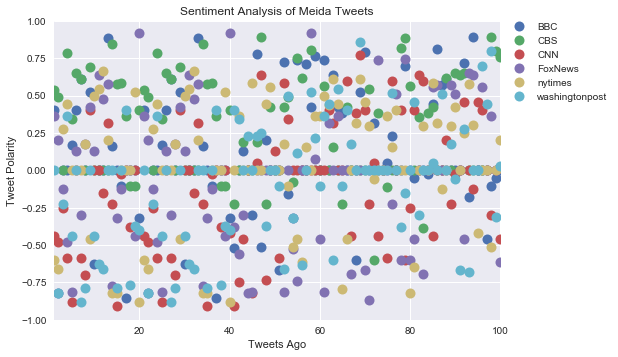

In [665]:
d.plot(marker = 'o', grid=True,style=' ', ms=10)
plt.legend(bbox_to_anchor=(1, 1.025))
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.title('Sentiment Analysis of Meida Tweets')
plt.ylim(-1,1)
plt.show();

In [590]:
import seaborn as sns

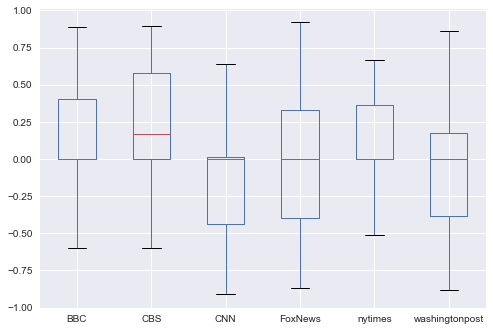

In [591]:
d.boxplot()
plt.show()

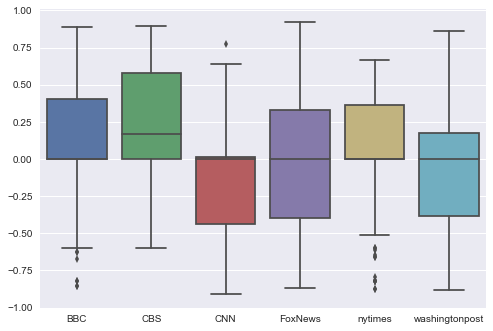

In [592]:
sns.boxplot(data=d)
plt.show()

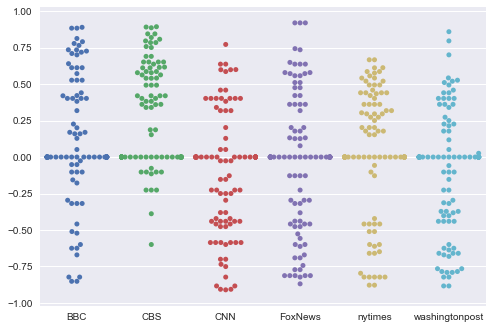

In [593]:
sns.swarmplot(data=d)
plt.show()

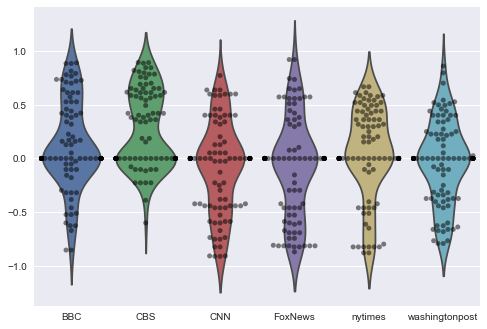

In [490]:
sns.violinplot(data=d, inner=None)
sns.swarmplot(data=d, color="black", alpha=.5)
plt.show();

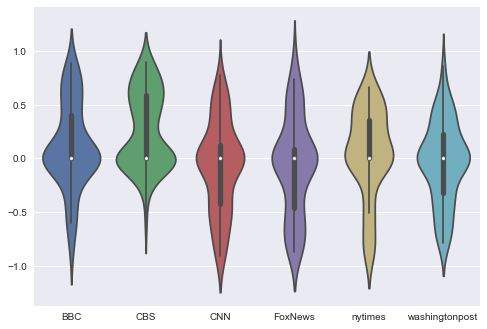

In [491]:
sns.violinplot(data=d)
plt.show();

In [503]:

d.BBC.mean()

0.11092299999999998

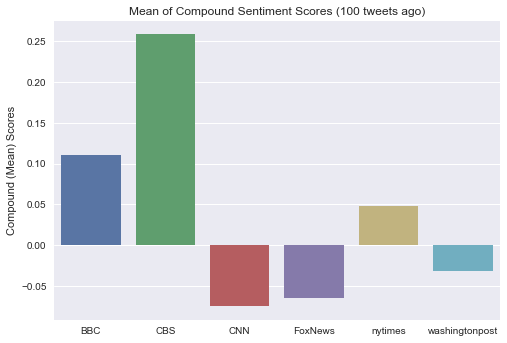

In [544]:
news_mood_overall={}
values=[]
for news in d:
    means=[]
    means.append(d[news].mean())
    news_mood_overall[news]=means
    values.append(d[news].mean())
    
    
news_mood_overall
news_ovar_all=pd.DataFrame(news_mood_overall)
#news_ovar_all.plot(kind='bar')
sns.barplot(data=news_ovar_all)
plt.title('Mean of Compound Sentiment Scores (100 tweets ago)')
plt.ylabel('Compound (Mean) Scores')
plt.show()

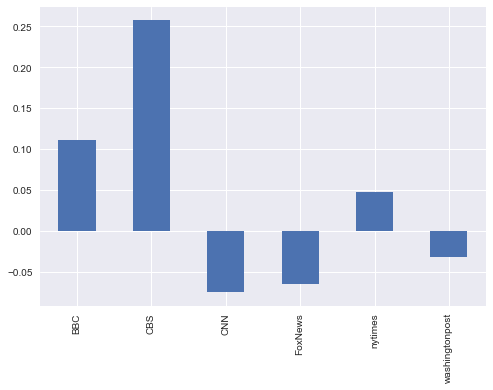

In [594]:
news_ovar_all.T.plot(kind='bar', legend=False)
plt.show()

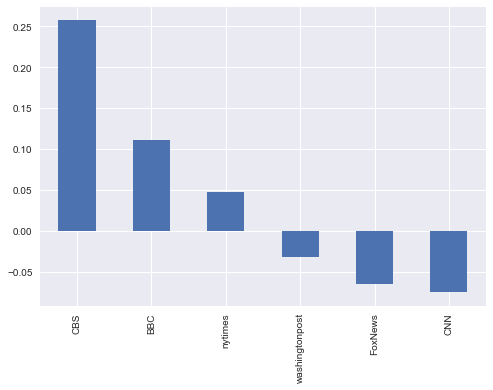

In [595]:
news_ovar_all.T.sort_values(by=0, ascending=False).plot(kind='bar', legend=False)
plt.show()

In [699]:
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]


In [700]:
arrays

[['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
 ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]

In [705]:
tuples1 = list(zip(*arrays))
tuples2 = list(zip(arrays))

In [706]:
tuples1 == tuples2

False

In [707]:
tuples1

[('bar', 'one'),
 ('bar', 'two'),
 ('baz', 'one'),
 ('baz', 'two'),
 ('foo', 'one'),
 ('foo', 'two'),
 ('qux', 'one'),
 ('qux', 'two')]

In [709]:
df = pd.DataFrame(np.random.randn(3, 8), index=['A', 'B', 'C'], columns)

SyntaxError: positional argument follows keyword argument (<ipython-input-709-9a155ff205f7>, line 1)

In [711]:
import numpy as np
df = pd.DataFrame(np.random.randn(3, 8), index=['A', 'B', 'C'], columns=index)


TypeError: len() of unsized object

In [712]:
df = pd.DataFrame(np.random.randn(8, 4), index=arrays)

In [715]:
df2=df.T

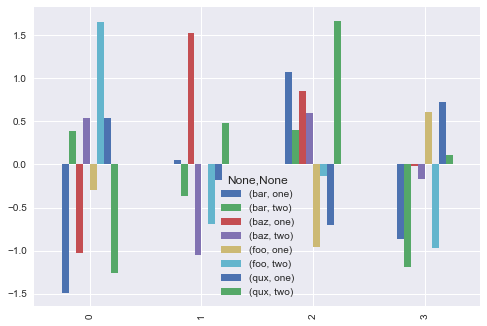

In [720]:
df2.plot(kind='bar')
plt.show()

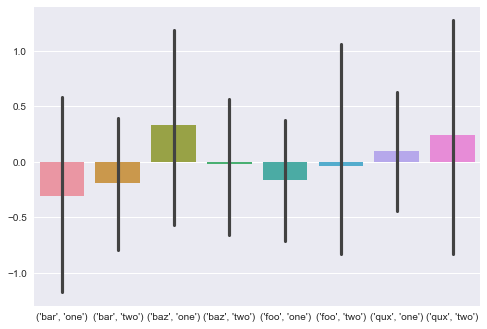

In [726]:
sns.barplot(data=df2)
plt.show()

In [727]:
df2

bar                 baz                 foo                 qux  \
        one       two       one       two       one       two       one   
0 -1.486099  0.390711 -1.030629  0.533805 -0.292186  1.650908  0.535110   
1  0.050756 -0.365851  1.525494 -1.052663  0.004734 -0.689650 -0.185299   
2  1.066396  0.394281  0.853051  0.598614 -0.953375 -0.130328 -0.697872   
3 -0.865320 -1.192098 -0.021629 -0.164942  0.602736 -0.967170  0.726440   

             
        two  
0 -1.262191  
1  0.476061  
2  1.665362  
3  0.104904

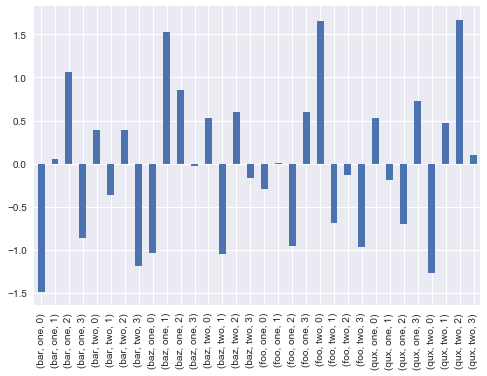

In [734]:
df2.unstack().plot(kind='bar')
plt.show()

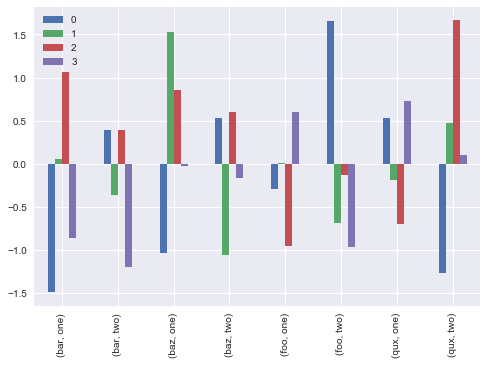

In [766]:
df.plot(kind='bar')
plt.show()

In [767]:
df

0         1         2         3
bar one -1.486099  0.050756  1.066396 -0.865320
    two  0.390711 -0.365851  0.394281 -1.192098
baz one -1.030629  1.525494  0.853051 -0.021629
    two  0.533805 -1.052663  0.598614 -0.164942
foo one -0.292186  0.004734 -0.953375  0.602736
    two  1.650908 -0.689650 -0.130328 -0.967170
qux one  0.535110 -0.185299 -0.697872  0.726440
    two -1.262191  0.476061  1.665362  0.104904

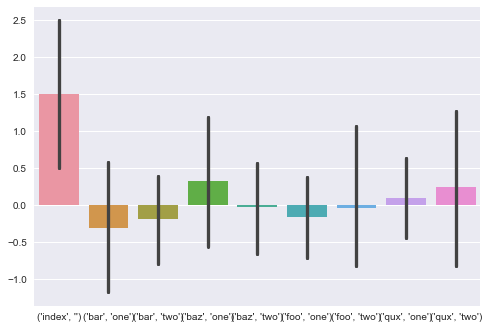

In [745]:
sns.barplot(data=d3)
plt.show()

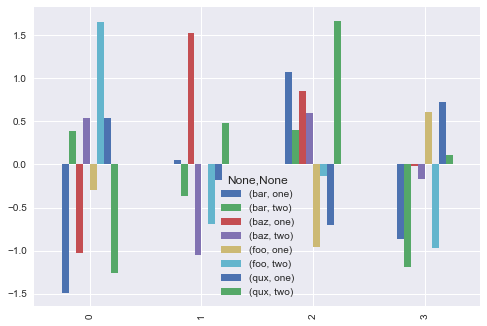

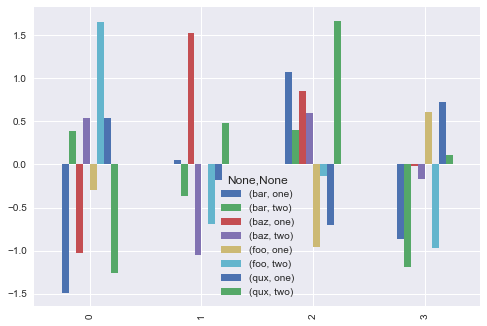

In [749]:
d3.plot(xkind='bar')
plt.show()

In [758]:
d3.columns


MultiIndex(levels=[['bar', 'baz', 'foo', 'qux'], ['one', 'two']],
           labels=[[0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 0, 1, 0, 1, 0, 1]])